In [1]:
#Import necessary libraries
import matplotlib.pyplot as plt
from pyspark.sql import SparkSession
from pyspark.sql.functions import col, count, avg, isnan, sum as spark_sum, approx_count_distinct
from pyspark.sql.functions import month, year, dayofmonth
import seaborn as sns
from pyspark.sql.functions import corr
from pyspark.sql.types import FloatType

In [2]:
spark = SparkSession.builder.appName("SpotifyPopularityPrediction").getOrCreate()

24/01/05 22:29:41 WARN Utils: Your hostname, Manishs-MacBook-Pro-13.local resolves to a loopback address: 127.0.0.1; using 192.168.1.66 instead (on interface en0)
24/01/05 22:29:41 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
24/01/05 22:29:42 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


In [3]:
# Assuming your dataset is in CSV format
data_path = "spotify_songs.csv"
df = spark.read.csv(data_path, header=True, inferSchema=True)

In [4]:
df.show(10)

+--------------------+--------------------+----------------+----------------+--------------------+--------------------+------------------------+-------------+--------------------+--------------+-----------------+------------+------+---+--------+----+-----------+------------+----------------+--------+-------+-------+-----------+
|            track_id|          track_name|    track_artist|track_popularity|      track_album_id|    track_album_name|track_album_release_date|playlist_name|         playlist_id|playlist_genre|playlist_subgenre|danceability|energy|key|loudness|mode|speechiness|acousticness|instrumentalness|liveness|valence|  tempo|duration_ms|
+--------------------+--------------------+----------------+----------------+--------------------+--------------------+------------------------+-------------+--------------------+--------------+-----------------+------------+------+---+--------+----+-----------+------------+----------------+--------+-------+-------+-----------+
|6f807x0im

## Exploratory Data Analysis

### Checking Type of Data in Dataset

In [5]:
df.printSchema()

root
 |-- track_id: string (nullable = true)
 |-- track_name: string (nullable = true)
 |-- track_artist: string (nullable = true)
 |-- track_popularity: integer (nullable = true)
 |-- track_album_id: string (nullable = true)
 |-- track_album_name: string (nullable = true)
 |-- track_album_release_date: string (nullable = true)
 |-- playlist_name: string (nullable = true)
 |-- playlist_id: string (nullable = true)
 |-- playlist_genre: string (nullable = true)
 |-- playlist_subgenre: string (nullable = true)
 |-- danceability: string (nullable = true)
 |-- energy: string (nullable = true)
 |-- key: string (nullable = true)
 |-- loudness: string (nullable = true)
 |-- mode: string (nullable = true)
 |-- speechiness: double (nullable = true)
 |-- acousticness: double (nullable = true)
 |-- instrumentalness: double (nullable = true)
 |-- liveness: double (nullable = true)
 |-- valence: double (nullable = true)
 |-- tempo: double (nullable = true)
 |-- duration_ms: double (nullable = true)


In [6]:
df.describe().show()

24/01/05 22:29:59 WARN SparkStringUtils: Truncated the string representation of a plan since it was too large. This behavior can be adjusted by setting 'spark.sql.debug.maxToStringFields'.


+-------+--------------------+--------------------+------------------+------------------+--------------------+------------------------+------------------------+--------------------+---------------+--------------------+------------------+-------------------+--------------------+------------------+-------------------+--------------------+-------------------+-------------------+-------------------+-------------------+-------------------+------------------+------------------+
|summary|            track_id|          track_name|      track_artist|  track_popularity|      track_album_id|        track_album_name|track_album_release_date|       playlist_name|    playlist_id|      playlist_genre| playlist_subgenre|       danceability|              energy|               key|           loudness|                mode|        speechiness|       acousticness|   instrumentalness|           liveness|            valence|             tempo|       duration_ms|
+-------+--------------------+----------------

In [7]:
df.count()

32833

### Checking a null value

In [8]:
# checking null values
null_counts = df.select([spark_sum(col(column).isNull().cast('int')).alias(column) for column in df.columns])

In [9]:
null_counts.show()

+--------+----------+------------+----------------+--------------+----------------+------------------------+-------------+-----------+--------------+-----------------+------------+------+---+--------+----+-----------+------------+----------------+--------+-------+-----+-----------+
|track_id|track_name|track_artist|track_popularity|track_album_id|track_album_name|track_album_release_date|playlist_name|playlist_id|playlist_genre|playlist_subgenre|danceability|energy|key|loudness|mode|speechiness|acousticness|instrumentalness|liveness|valence|tempo|duration_ms|
+--------+----------+------------+----------------+--------------+----------------+------------------------+-------------+-----------+--------------+-----------------+------------+------+---+--------+----+-----------+------------+----------------+--------+-------+-----+-----------+
|       0|         0|           0|               0|             0|               0|                       0|            0|          0|             0|  

In [10]:
nan_counts = df.select([count(isnan(col(column))).alias(column) for column in df.columns])
nan_counts.show()

+--------+----------+------------+----------------+--------------+----------------+------------------------+-------------+-----------+--------------+-----------------+------------+------+-----+--------+-----+-----------+------------+----------------+--------+-------+-----+-----------+
|track_id|track_name|track_artist|track_popularity|track_album_id|track_album_name|track_album_release_date|playlist_name|playlist_id|playlist_genre|playlist_subgenre|danceability|energy|  key|loudness| mode|speechiness|acousticness|instrumentalness|liveness|valence|tempo|duration_ms|
+--------+----------+------------+----------------+--------------+----------------+------------------------+-------------+-----------+--------------+-----------------+------------+------+-----+--------+-----+-----------+------------+----------------+--------+-------+-----+-----------+
|   32833|     32833|       32833|           32833|         32833|           32833|                   32833|        32833|      32833|        

In [11]:
columns_to_fill = ['track_name', 'track_artist', 'track_album_name']
for column in columns_to_fill:
    df = df.na.fill('unknown', [column])

df.show(10)

+--------------------+--------------------+----------------+----------------+--------------------+--------------------+------------------------+-------------+--------------------+--------------+-----------------+------------+------+---+--------+----+-----------+------------+----------------+--------+-------+-------+-----------+
|            track_id|          track_name|    track_artist|track_popularity|      track_album_id|    track_album_name|track_album_release_date|playlist_name|         playlist_id|playlist_genre|playlist_subgenre|danceability|energy|key|loudness|mode|speechiness|acousticness|instrumentalness|liveness|valence|  tempo|duration_ms|
+--------------------+--------------------+----------------+----------------+--------------------+--------------------+------------------------+-------------+--------------------+--------------+-----------------+------------+------+---+--------+----+-----------+------------+----------------+--------+-------+-------+-----------+
|6f807x0im

### Checking duplicated value

In [12]:
# checking duplicate values
duplicate_count = df.count() - df.dropDuplicates().count()
duplicate_count

0

### Split the track_album_release_date column

In [13]:
df = df.withColumn('album_release_month', month('track_album_release_date'))
df = df.withColumn('album_release_year', year('track_album_release_date'))
df = df.withColumn('album_release_day', dayofmonth('track_album_release_date'))

df.show(10)

+--------------------+--------------------+----------------+----------------+--------------------+--------------------+------------------------+-------------+--------------------+--------------+-----------------+------------+------+---+--------+----+-----------+------------+----------------+--------+-------+-------+-----------+-------------------+------------------+-----------------+
|            track_id|          track_name|    track_artist|track_popularity|      track_album_id|    track_album_name|track_album_release_date|playlist_name|         playlist_id|playlist_genre|playlist_subgenre|danceability|energy|key|loudness|mode|speechiness|acousticness|instrumentalness|liveness|valence|  tempo|duration_ms|album_release_month|album_release_year|album_release_day|
+--------------------+--------------------+----------------+----------------+--------------------+--------------------+------------------------+-------------+--------------------+--------------+-----------------+------------+-

In [14]:
columns_to_drop = ['track_id', 'track_album_id', 'playlist_id', 'duration_ms', 'track_album_release_date']
df = df.select([col(column) for column in df.columns if column not in columns_to_drop])
df.show(10)

+--------------------+----------------+----------------+--------------------+-------------+--------------+-----------------+------------+------+---+--------+----+-----------+------------+----------------+--------+-------+-------+-------------------+------------------+-----------------+
|          track_name|    track_artist|track_popularity|    track_album_name|playlist_name|playlist_genre|playlist_subgenre|danceability|energy|key|loudness|mode|speechiness|acousticness|instrumentalness|liveness|valence|  tempo|album_release_month|album_release_year|album_release_day|
+--------------------+----------------+----------------+--------------------+-------------+--------------+-----------------+------------+------+---+--------+----+-----------+------------+----------------+--------+-------+-------+-------------------+------------------+-----------------+
|I Don't Care (wit...|      Ed Sheeran|              66|I Don't Care (wit...|    Pop Remix|           pop|        dance pop|       0.748| 0

### Distribution of Songs by Year of Release

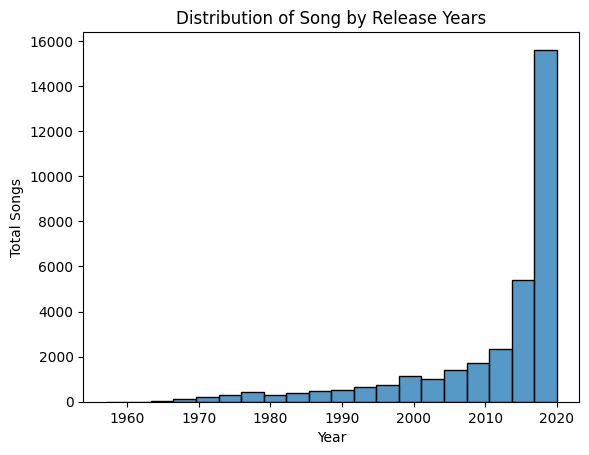

In [15]:
pandas_df = df.select("album_release_year").toPandas()
sns.histplot(x='album_release_year', data=pandas_df, bins=20)
plt.xlabel('Year')
plt.ylabel('Total Songs')
plt.title('Distribution of Song by Release Years')
plt.show()

### Music Trend per Decade by Acousticness

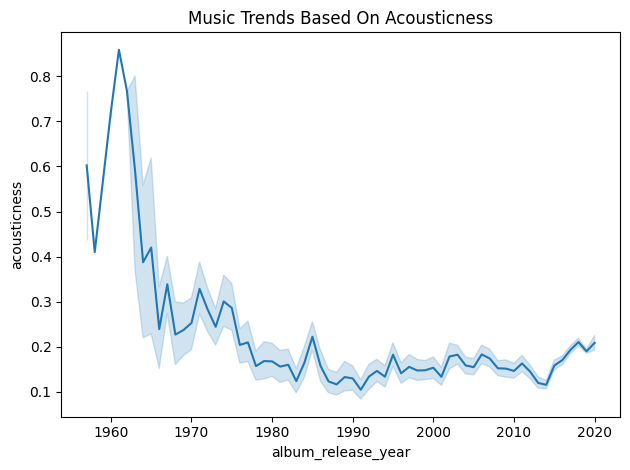

In [16]:
pandas_df = df.select("album_release_year", "acousticness").toPandas()
sns.lineplot(x='album_release_year', y='acousticness', data=pandas_df)
plt.title("Music Trends Based On Acousticness")
plt.tight_layout()
plt.show()

### Music Trend per Decade by Liveness

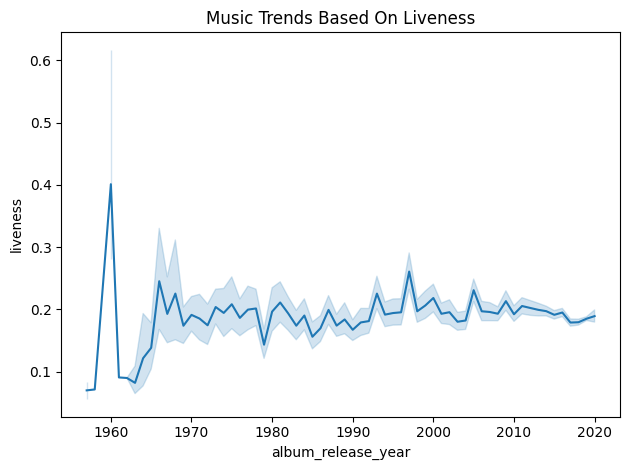

In [17]:
pandas_df = df.select("album_release_year", "liveness").toPandas()
sns.lineplot(x='album_release_year', y='liveness', data=pandas_df)
plt.title("Music Trends Based On Liveness")
plt.tight_layout()
plt.show()

### Music Trend per Decade by Tempo

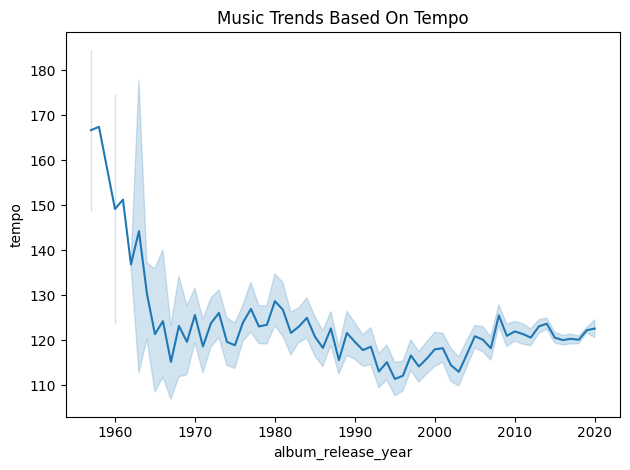

In [18]:
pandas_df = df.select("album_release_year", "tempo").toPandas()
sns.lineplot(x='album_release_year', y='tempo', data=pandas_df)
plt.title("Music Trends Based On Tempo")
plt.tight_layout()
plt.show()

### Total Song & Total Artist by Genre

In [19]:
genre = df.groupBy('playlist_genre').agg(
    count('track_name').alias('total_song'),
    approx_count_distinct('track_artist').alias('total_artist')
)

genre.show()

+--------------------+----------+------------+
|      playlist_genre|total_song|total_artist|
+--------------------+----------+------------+
|                 pop|      5506|        2407|
|                 rap|      5746|        2260|
|1E5VdGGWkpDQ682gd...|         1|           1|
|                rock|      4951|        1614|
|               latin|      5155|        2280|
|                 r&b|      5421|        2127|
|                 edm|      6042|        2520|
|5EMARioe9z9eKOeWI...|         1|           1|
|4425cRh83Uzor4qCR...|         3|           1|
|48AzM7l4M02DBYd2N...|         2|           1|
|6wyJ4bsjZaUKa9f6G...|         1|           1|
| Matthias Heilbro...|         1|           1|
|0JmBB9HfrzDiZoPVR...|         2|           1|
|37i9dQZF1DWTDafB3...|         1|           1|
+--------------------+----------+------------+



In [20]:
allowed_genres = ['pop', 'rap', 'rock', 'latin', 'edm', 'r&b']
filtered_genre_stats = genre.filter(col('playlist_genre').isin(allowed_genres))
filtered_genre_stats.show()

+--------------+----------+------------+
|playlist_genre|total_song|total_artist|
+--------------+----------+------------+
|           pop|      5506|        2407|
|           rap|      5746|        2260|
|          rock|      4951|        1614|
|         latin|      5155|        2280|
|           r&b|      5421|        2127|
|           edm|      6042|        2520|
+--------------+----------+------------+



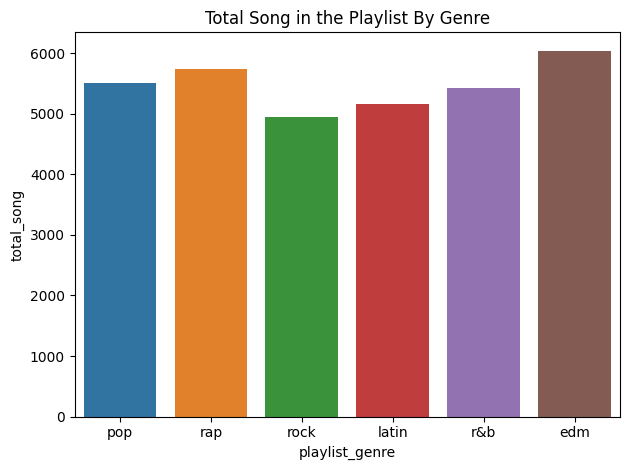

In [21]:
pandas_genre = filtered_genre_stats.toPandas()
sns.barplot(x='playlist_genre', y='total_song', data=pandas_genre)
plt.title("Total Song in the Playlist By Genre")
plt.tight_layout()
plt.show()

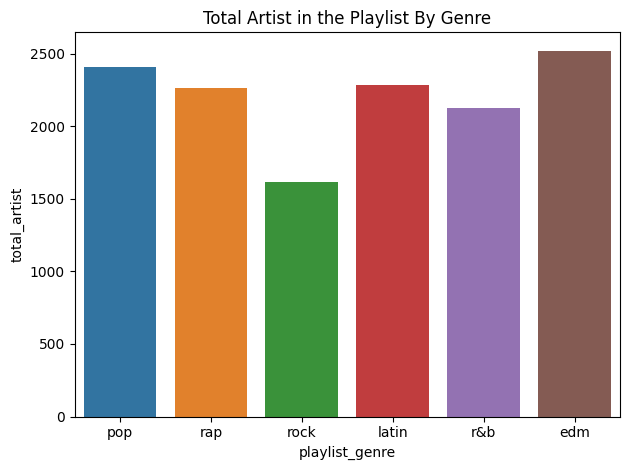

In [22]:
sns.barplot(x='playlist_genre', y='total_artist', data=pandas_genre)
plt.title("Total Artist in the Playlist By Genre")
plt.tight_layout()
plt.show()

### Top 5 Artist by Track Popularity

In [23]:
popular = df.filter(col('track_popularity') > 70)
popular.show()

+--------------------+-------------------+----------------+--------------------+-------------+--------------+-----------------+------------+------+---+--------+----+-----------+------------+----------------+--------+-------+-------+-------------------+------------------+-----------------+
|          track_name|       track_artist|track_popularity|    track_album_name|playlist_name|playlist_genre|playlist_subgenre|danceability|energy|key|loudness|mode|speechiness|acousticness|instrumentalness|liveness|valence|  tempo|album_release_month|album_release_year|album_release_day|
+--------------------+-------------------+----------------+--------------------+-------------+--------------+-----------------+------------+------+---+--------+----+-----------+------------+----------------+--------+-------+-------+-------------------+------------------+-----------------+
|         Higher Love|               Kygo|              87|         Higher Love|    Pop Remix|           pop|        dance pop|   

In [24]:
# Get song counts by artist
song_counts = popular.groupBy('track_artist').agg(count('*').alias('song_count'))
popular = popular.join(song_counts, 'track_artist').filter(col('song_count') > 10)
popular.show()

+-------------------+--------------------+----------------+--------------------+-------------+--------------+-----------------+------------+------+---+--------+----+-----------+------------+----------------+--------+-------+-------+-------------------+------------------+-----------------+----------+
|       track_artist|          track_name|track_popularity|    track_album_name|playlist_name|playlist_genre|playlist_subgenre|danceability|energy|key|loudness|mode|speechiness|acousticness|instrumentalness|liveness|valence|  tempo|album_release_month|album_release_year|album_release_day|song_count|
+-------------------+--------------------+----------------+--------------------+-------------+--------------+-----------------+------------+------+---+--------+----+-----------+------------+----------------+--------+-------+-------+-------------------+------------------+-----------------+----------+
|               Kygo|         Higher Love|              87|         Higher Love|    Pop Remix|   

In [25]:
avg_popular = popular.groupBy('track_artist').agg(avg('track_popularity').alias('avg_popularity'))

In [26]:
top_artist_by_avg_popular = avg_popular.orderBy(col('avg_popularity').desc()).limit(5)

In [27]:
top_artist_by_song_count = song_counts.orderBy(col('song_count').desc()).limit(5)

In [28]:
top_artist_by_avg_popular.show()
top_artist_by_song_count.show()

+-------------+-----------------+
| track_artist|   avg_popularity|
+-------------+-----------------+
|Lewis Capaldi|89.93333333333334|
|     Dua Lipa|          89.4375|
|       DaBaby| 89.3076923076923|
|       Future|88.54545454545455|
|  Roddy Ricch|88.21052631578948|
+-------------+-----------------+

+-------------+----------+
| track_artist|song_count|
+-------------+----------+
|Calvin Harris|        47|
|   Ed Sheeran|        43|
|       Khalid|        42|
|Martin Garrix|        42|
|Billie Eilish|        40|
+-------------+----------+



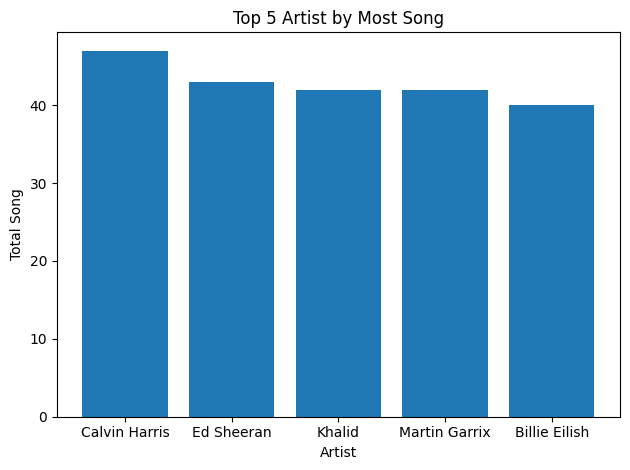

In [29]:
pandas_top_artist = top_artist_by_song_count.toPandas()
plt.bar(pandas_top_artist['track_artist'], pandas_top_artist['song_count'])
plt.title("Top 5 Artist by Most Song")
plt.xlabel("Artist")
plt.ylabel("Total Song")
plt.tight_layout()
plt.show()

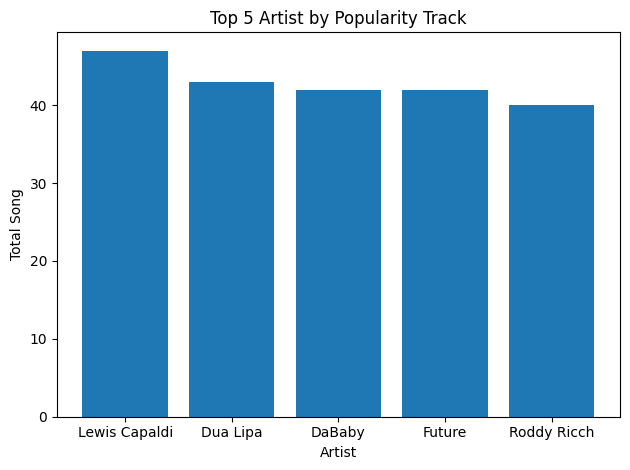

In [30]:
pandas_popular_artist = top_artist_by_avg_popular.toPandas()
plt.bar(pandas_popular_artist['track_artist'], pandas_top_artist['song_count'])
plt.title("Top 5 Artist by Popularity Track")
plt.xlabel("Artist")
plt.ylabel("Total Song")
plt.tight_layout()
plt.show()

## Predict a Song Track Popularity

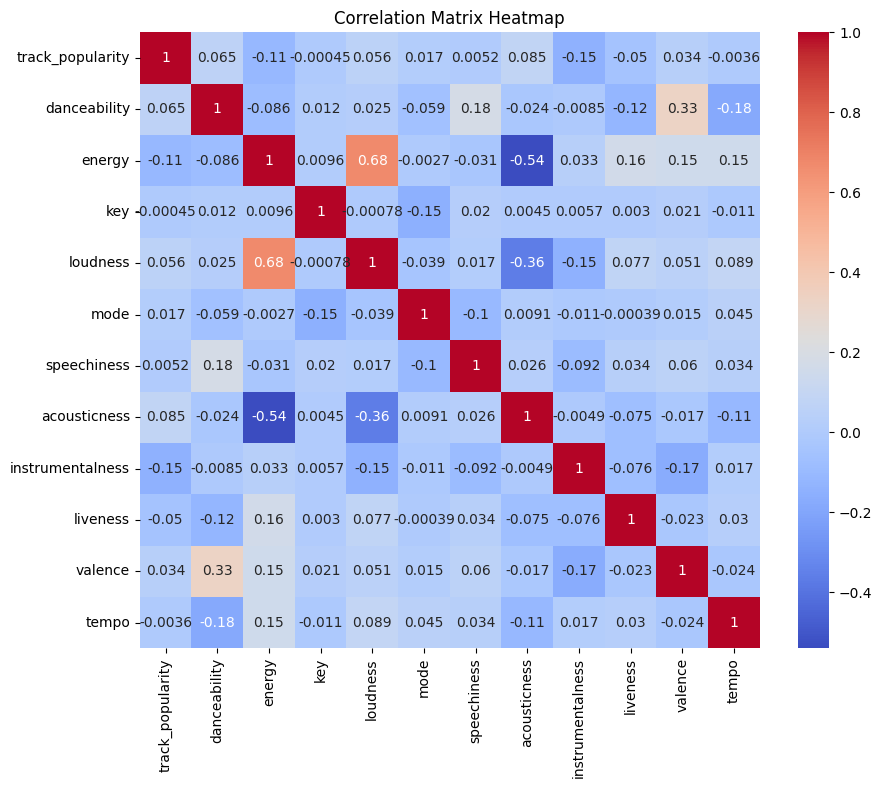

In [31]:
mat_col = ['track_popularity', 'danceability', 'energy', 'key', 'loudness', 'mode', 
           'speechiness', 'acousticness', 'instrumentalness', 'liveness', 'valence', 'tempo']
selected_df = df.select(mat_col)
for column in mat_col:
    selected_df = selected_df.withColumn(column, col(column).cast(FloatType()))
pandas_df = selected_df.toPandas()
corr_mat = pandas_df[mat_col].corr()
# Plot the correlation matrix heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(corr_mat, annot=True, cmap='coolwarm')
plt.title('Correlation Matrix Heatmap')
plt.show()

### Removing Outlier

In [32]:
def outlier_thresholds(dataframe, col_name, q1=0.05, q3=0.95):
    quantiles = dataframe.approxQuantile(col_name, [q1, q3], 0.05)
    quartile1 = quantiles[0]
    quartile3 = quantiles[1]
    interquantile_range = quartile3 - quartile1
    up_limit = quartile3 + 1.5 * interquantile_range
    low_limit = quartile1 - 1.5 * interquantile_range
    return low_limit, up_limit

# Function to check for outliers
def check_outlier(dataframe, cname):
    low_limit, up_limit = outlier_thresholds(dataframe, cname)
    return dataframe.filter((col(cname) > up_limit) | (col(cname) < low_limit)).count() > 0

In [33]:
df = df.withColumn("danceability", col("danceability").cast(FloatType()))
df = df.withColumn("energy", col("energy").cast(FloatType()))
df = df.withColumn("key", col("key").cast(FloatType()))
df = df.withColumn("loudness", col("loudness").cast(FloatType()))
df = df.withColumn("mode", col("mode").cast(FloatType()))
df = df.withColumn("speechiness", col("speechiness").cast(FloatType()))
df = df.withColumn("acousticness", col("acousticness").cast(FloatType()))
df = df.withColumn("instrumentalness", col("instrumentalness").cast(FloatType()))
df = df.withColumn("liveness", col("liveness").cast(FloatType()))
df = df.withColumn("valence", col("valence").cast(FloatType()))
df = df.withColumn("tempo", col("tempo").cast(FloatType()))
for column_name in mat_col:
    has_outliers = check_outlier(df, column_name)
    print(f"{column_name}: {'Outliers present' if has_outliers else 'No outliers'}")

track_popularity: No outliers
danceability: No outliers
energy: No outliers
key: No outliers
loudness: No outliers
mode: No outliers
speechiness: No outliers
acousticness: No outliers
instrumentalness: No outliers
liveness: No outliers
valence: No outliers
tempo: No outliers


### Feature Selection

In [34]:
features_df = df.dropna().select([col for col in mat_col])
features = [col for col in mat_col if col != 'track_popularity']

In [35]:
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.regression import RandomForestRegressor
from pyspark.ml.evaluation import RegressionEvaluator

vec_assembler = VectorAssembler(inputCols=features, outputCol="features")
assembled_data = vec_assembler.transform(features_df)


In [36]:
train_data, test_data = assembled_data.randomSplit([0.8, 0.2], seed=42)

In [37]:
rf = RandomForestRegressor(featuresCol="features", labelCol="track_popularity")
model = rf.fit(train_data)

In [38]:
predictions = model.transform(test_data)

In [39]:
evaluator = RegressionEvaluator(labelCol="track_popularity", predictionCol="prediction", metricName="rmse")
rmse = evaluator.evaluate(predictions)
print(f"Root Mean Squared Error (RMSE): {rmse}")

Root Mean Squared Error (RMSE): 23.80169309082545


In [40]:
from pyspark.ml.regression import LinearRegression

# Create a Linear Regression model
lr = LinearRegression(featuresCol="features", labelCol="track_popularity")

# Train the model
model = lr.fit(train_data)

# Make predictions
predictions = model.transform(test_data)

# Evaluate the model
evaluator = RegressionEvaluator(labelCol="track_popularity", predictionCol="prediction", metricName="rmse")
rmse = evaluator.evaluate(predictions)
print(f"Root Mean Squared Error (RMSE): {rmse}")

24/01/05 22:31:25 WARN Instrumentation: [771ddfd4] regParam is zero, which might cause numerical instability and overfitting.
24/01/05 22:31:25 WARN InstanceBuilder: Failed to load implementation from:dev.ludovic.netlib.blas.JNIBLAS
24/01/05 22:31:25 WARN InstanceBuilder: Failed to load implementation from:dev.ludovic.netlib.lapack.JNILAPACK


Root Mean Squared Error (RMSE): 24.045035500042225
